In [2]:
import pandas as pd

df = pd.read_csv("Ph2_dataset_2.csv", header=1)

def assign_label(row):
    if row["Common Nevus"] == "X":
        return 0  
    elif row["Atypical Nevus"] == "X":
        return 1 
    elif row["Melanoma"] == "X":
        return 2  
    else:
        return -1 

df["label"] = df.apply(assign_label, axis=1)

print(df["label"].value_counts())

label
0    80
1    80
2    40
Name: count, dtype: int64


In [ ]:
df.rename(columns={
    "Asymmetry\n(0/1/2)": "Asymmetry",
    "Pigment Network\n(AT/T)": "PigmentNetwork",
    "Dots/Globules\n(A/AT/T)": "DotsGlobules",
    "Streaks\n(A/P)": "Streaks",
    "Regression Areas\n(A/P)": "RegressionAreas",
    "Blue-Whitish Veil\n(A/P)": "BlueWhitishVeil"
}, inplace=True)

def assign_label(row):
    # 우선 "Common Nevus", "Atypical Nevus", "Melanoma" 중 한 곳에만 'X'가 있다고 가정
    if row["Common Nevus"] == "X":
        return 0
    elif row["Atypical Nevus"] == "X":
        return 1
    elif row["Melanoma"] == "X":
        return 2
    else:
        return -1  # 라벨이 없는 경우, 추후 필터링

df["label"] = df.apply(assign_label, axis=1)
print(df["label"].value_counts())

label
0    80
1    80
2    40
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

import os

BASE_DIR = "/home/min/main/Ph2"
IMAGES_DIR = os.path.join(BASE_DIR, "PH2 Dataset images")

cases = []
for idx, row in df.iterrows():
    case_id = row["Image Name"]
    derm_path = os.path.join(IMAGES_DIR, case_id, f"{case_id}_Dermoscopic_Image", f"{case_id}.bmp")
    label = row["label"]
    if label != -1:
        cases.append((derm_path, label))

train_val, test = train_test_split(cases, test_size=0.15, stratify=[lbl for _, lbl in cases], random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, stratify=[lbl for _, lbl in train_val], random_state=42)

print(f"Train samples: {len(train)}, Validation samples: {len(val)}, Test samples: {len(test)}")


Train samples: 139, Validation samples: 31, Test samples: 30


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

class PH2Dataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list  # list of (img_path, label)
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform_train = T.Compose([
    # RandomResizedCrop: 이미지에서 무작위로 crop하고, 지정된 크기로 리사이즈 (scale과 ratio 조절 가능)
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # RandomHorizontalFlip: 수평으로 랜덤 반전
    T.RandomHorizontalFlip(),
    # RandomRotation: ±20도 내외로 회전
    T.RandomRotation(degrees=20),
    # ColorJitter: 밝기, 대비, 채도, 색조에 변화 적용
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


ds_train = PH2Dataset(train, transform=transform_train)
ds_val   = PH2Dataset(val, transform=transform_val)
ds_test  = PH2Dataset(test, transform=transform_val)

dl_train = DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=2)
dl_val   = DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=2)
dl_test  = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('vit_base_patch16_224', pretrained=True)

num_features = model.get_classifier().in_features
model.reset_classifier(num_classes=3)

model = model.to(device)  

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import copy

num_epochs = 50
patience = 10
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    for images, labels in tqdm(dl_train, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        running_correct += (preds == labels).sum().item()
    train_loss = running_loss / total_train
    train_acc = running_correct / total_train

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in dl_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (preds == labels).sum().item()
    val_loss = val_loss / total_val
    val_acc = val_correct / total_val
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_vit_model.pth")
        print(f"Best model saved with Val Acc: {best_val_acc:.4f}")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)
model.eval()
test_loss = 0.0
test_correct = 0
total_test = 0
with torch.no_grad():
    for images, labels in dl_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_test += labels.size(0)
        test_correct += (preds == labels).sum().item()
test_loss = test_loss / total_test
test_acc = test_correct / total_test
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Training Epoch 1: 100%|██████████| 9/9 [00:00<00:00,  9.24it/s]


Epoch 1/50 | Train Loss: 0.5501 Acc: 0.7410 | Val Loss: 1.0628 Acc: 0.6129
Best model saved with Val Acc: 0.6129


Training Epoch 2: 100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


Epoch 2/50 | Train Loss: 0.6304 Acc: 0.7194 | Val Loss: 1.1579 Acc: 0.4194


Training Epoch 3: 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


Epoch 3/50 | Train Loss: 0.5571 Acc: 0.7698 | Val Loss: 0.9932 Acc: 0.5806


Training Epoch 4: 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


Epoch 4/50 | Train Loss: 0.5787 Acc: 0.7194 | Val Loss: 1.6704 Acc: 0.4839


Training Epoch 5: 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


Epoch 5/50 | Train Loss: 0.6689 Acc: 0.6835 | Val Loss: 0.9953 Acc: 0.6129


Training Epoch 6: 100%|██████████| 9/9 [00:00<00:00,  9.14it/s]


Epoch 6/50 | Train Loss: 0.5127 Acc: 0.7338 | Val Loss: 1.0908 Acc: 0.4839


Training Epoch 7: 100%|██████████| 9/9 [00:00<00:00,  9.26it/s]


Epoch 7/50 | Train Loss: 0.4574 Acc: 0.7986 | Val Loss: 1.3080 Acc: 0.6774
Best model saved with Val Acc: 0.6774


Training Epoch 8: 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


Epoch 8/50 | Train Loss: 0.4546 Acc: 0.7986 | Val Loss: 1.0903 Acc: 0.5484


Training Epoch 9: 100%|██████████| 9/9 [00:00<00:00,  9.28it/s]


Epoch 9/50 | Train Loss: 0.4437 Acc: 0.7770 | Val Loss: 1.2444 Acc: 0.4194


Training Epoch 10: 100%|██████████| 9/9 [00:00<00:00,  9.28it/s]


Epoch 10/50 | Train Loss: 0.4151 Acc: 0.8129 | Val Loss: 1.3996 Acc: 0.6774


Training Epoch 11: 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


Epoch 11/50 | Train Loss: 0.3906 Acc: 0.8129 | Val Loss: 1.5140 Acc: 0.6452


Training Epoch 12: 100%|██████████| 9/9 [00:00<00:00,  9.32it/s]


Epoch 12/50 | Train Loss: 0.3352 Acc: 0.8633 | Val Loss: 1.3417 Acc: 0.5484


Training Epoch 13: 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


Epoch 13/50 | Train Loss: 0.2941 Acc: 0.8777 | Val Loss: 1.5936 Acc: 0.6452


Training Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 25.89it/s]


Epoch 14/50 | Train Loss: 0.2542 Acc: 0.8921 | Val Loss: 1.4300 Acc: 0.5806


Training Epoch 15: 100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


Epoch 15/50 | Train Loss: 0.2842 Acc: 0.8705 | Val Loss: 1.6100 Acc: 0.6774


Training Epoch 16: 100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


Epoch 16/50 | Train Loss: 0.2413 Acc: 0.8993 | Val Loss: 1.5459 Acc: 0.5484


Training Epoch 17: 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


Epoch 17/50 | Train Loss: 0.1581 Acc: 0.9496 | Val Loss: 1.6301 Acc: 0.6452
Early stopping at epoch 17
Test Loss: 0.8994, Test Acc: 0.6667


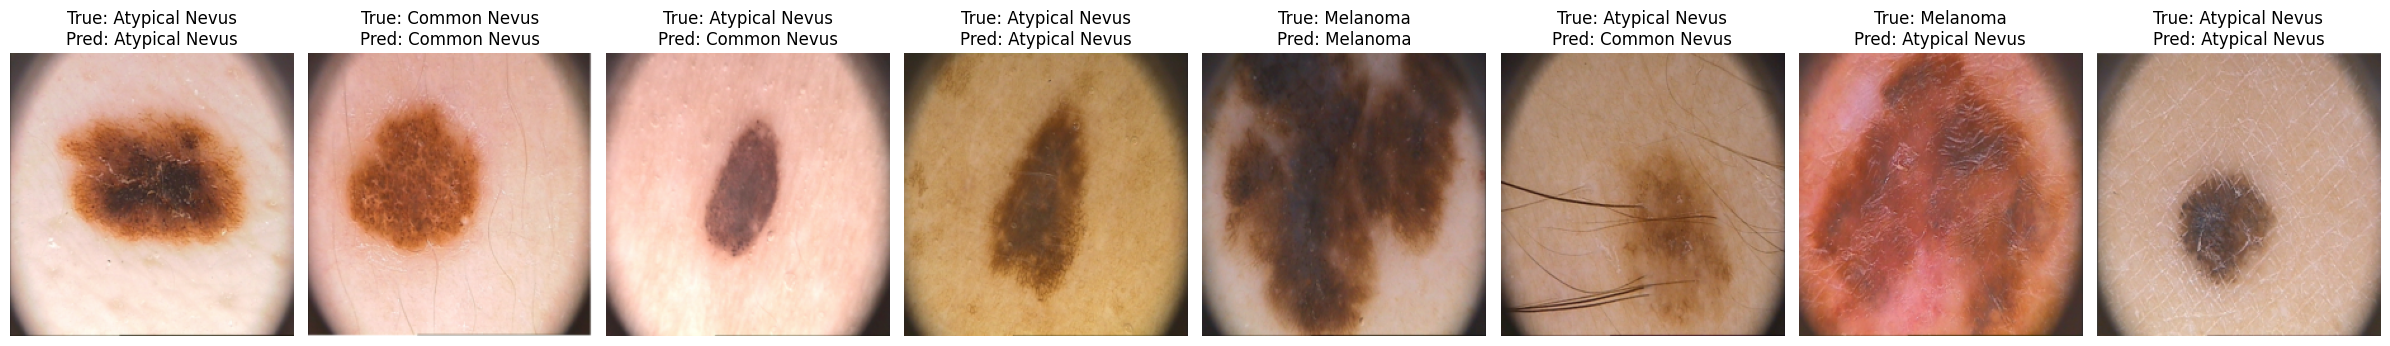

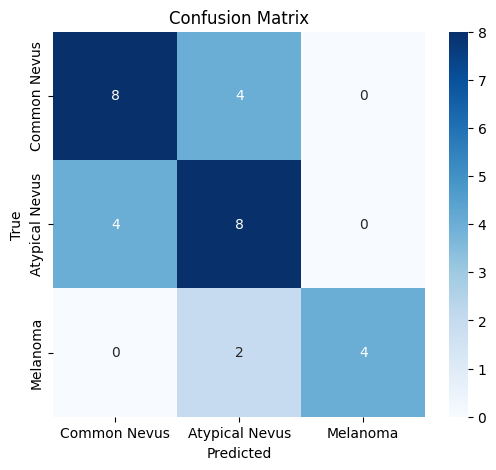

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ["Common Nevus", "Atypical Nevus", "Melanoma"]

def visualize_predictions(model, dataloader, class_names, device, num_images=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(1, num_images, figsize=(3*num_images, 4))
    for i in range(num_images):
        img = images[i]
        img = np.transpose(img, (1, 2, 0))
        img = std * img + mean  
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(model, dl_test, class_names, device, num_images=8)

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in dl_test:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()